$P(x) = a_0 + a_1x + a_2x^2 + a_3x^3 + a_4x^4 + a_5x^5$

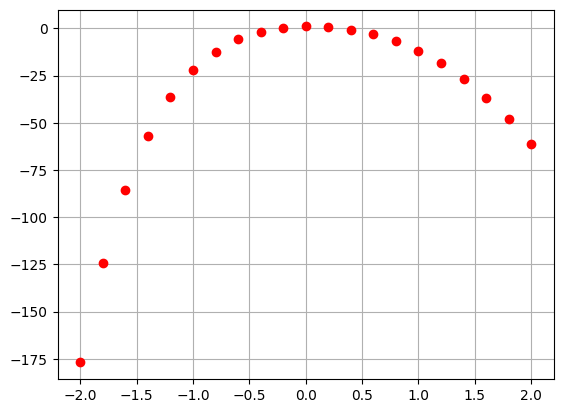

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

# Cargar el dataset
ruta = '/Users/ferleon/Github/semestre_v/algoritmos_bioinspirados/data/data.xlsx'
df_polar = pl.read_excel(ruta)

df = pl.read_excel(ruta)
x = df['x'].to_numpy()
y = df['y'].to_numpy()
plt.plot(x,y,'ro')
plt.grid()
plt.show()

In [69]:
from sklearn.metrics import mean_squared_error


# Normaliza x (evita x**k gigantes)
x_raw = df['x'].to_numpy()
y = df['y'].to_numpy()
x_mu = float(np.mean(x_raw))
x_sigma = float(np.std(x_raw) + 1e-12)
x = (x_raw - x_mu) / x_sigma

def _polyval_horner(coeffs, xvec):
    a0,a1,a2,a3,a4,a5 = coeffs
    return (((((a5*xvec)+a4)*xvec+a3)*xvec+a2)*xvec+a1)*xvec+a0



def c_error_cuadratico(poblacion, x, y, alpha=1e-3):
    errores = []
    for coef in poblacion:
        y_pred = _polyval_horner(coef, x)
        if not np.all(np.isfinite(y_pred)):
            err = np.inf
        else:
            # regularización L2 para evitar coeficientes monstruo
            err = mean_squared_error(y, y_pred) + alpha * np.sum(coef**2)
        errores.append(err)
    poblacion_error = np.column_stack((poblacion, np.array(errores)))
    poblacion_error = poblacion_error[np.argsort(poblacion_error[:, -1])]
    return poblacion_error


In [70]:
def BUMDA_MEDIA_STDS(poblacion_elite, g, min_val, max_val, beta):
    m, d = poblacion_elite.shape
    g = np.asarray(g, float)
    g = g - np.max(g)                 # estabilidad numérica
    w = np.exp(beta * g)
    w /= (np.sum(w) + 1e-12)

    mu = np.zeros(d); sigma = np.zeros(d)
    span = (max_val - min_val)
    for j in range(d):
        xj = poblacion_elite[:, j]
        mu_j = float(np.sum(w * xj))
        var_j = float(np.sum(w * (xj - mu_j)**2))
        sj = np.sqrt(np.maximum(var_j, 1e-6))
        sigma[j] = float(np.clip(sj, 1e-3, span))
        mu[j] = mu_j

    # fallback si algo se volvió NaN/inf
    if (not np.all(np.isfinite(mu))) or (not np.all(np.isfinite(sigma))):
        mu = np.nan_to_num(mu, nan=0.0, posinf=0.0, neginf=0.0)
        sigma = np.nan_to_num(sigma, nan=0.5, posinf=span, neginf=1e-3)
    return mu, sigma

In [71]:
def truncamiento_y_modelo(poblacion_error, ps):
    seleccionados = poblacion_error[:ps, :-1]

    return seleccionados

In [72]:
def generar_nueva_poblacion(medias, sigmas, n, coef_min=-10.0, coef_max=10.0):
    nueva = np.random.normal(medias, sigmas, size=(n, len(medias)))
    return np.clip(nueva, coef_min, coef_max)

Gen   1 | best MSE = 400.170860
Gen   2 | best MSE = 263.013198
Gen   3 | best MSE = 1620.300878
Gen   4 | best MSE = 1955.972389
Gen   5 | best MSE = 2236.922439
Gen   6 | best MSE = 2771.235614
Gen   7 | best MSE = 2880.852260
Gen   8 | best MSE = 2920.063064
Gen   9 | best MSE = 2942.194748
Gen  10 | best MSE = 2961.132101
Gen  11 | best MSE = 2971.192749
Gen  12 | best MSE = 2971.670964
Gen  13 | best MSE = 2981.208482
Gen  14 | best MSE = 2983.838263
Gen  15 | best MSE = 2984.527698
Gen  16 | best MSE = 2984.413323
Gen  17 | best MSE = 2984.438668
Gen  18 | best MSE = 2984.250318
Gen  19 | best MSE = 2984.433182
Gen  20 | best MSE = 2984.382196
Gen  21 | best MSE = 2984.517531
Gen  22 | best MSE = 2984.389750
Gen  23 | best MSE = 2984.642739
Gen  24 | best MSE = 2984.370502
Gen  25 | best MSE = 2984.817179
Gen  26 | best MSE = 2984.497362
Gen  27 | best MSE = 2984.641069
Gen  28 | best MSE = 2984.639758
Gen  29 | best MSE = 2984.691478
Gen  30 | best MSE = 2984.595677
Gen  31 | be

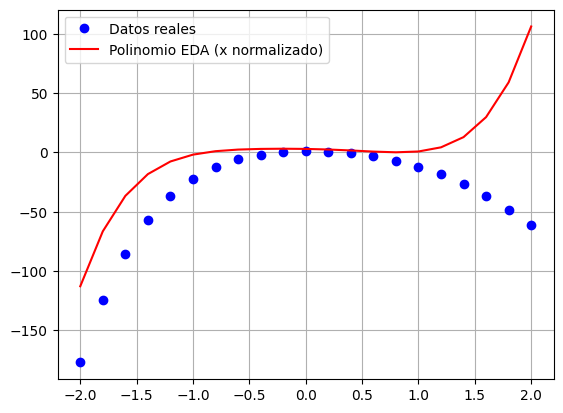

In [81]:
np.random.seed(42)
num_generaciones = 20000
tam_poblacion = 150
ps = tam_poblacion // 2
poblacion = np.random.uniform(-10.0, 10.0, size=(tam_poblacion, 6))

for gen in range(num_generaciones):
    poblacion_error = c_error_cuadratico(poblacion, x, y, alpha=1e-3)
    # Log corto para monitorear estabilidad
    print(f"Gen {gen+1:3d} | best MSE = {poblacion_error[0, -1]:.6f}")
    seleccionados = poblacion_error[:ps, :-1]

    # Puedes annealar beta si quieres: beta = 0.5 + 0.5*(gen/num_generaciones)
    medias, sigmas = BUMDA_MEDIA_STDS(
        seleccionados,
        g=np.arange(1, ps+1),
        min_val=-10.0,
        max_val=10.0,
        beta=0.8,
    )

    poblacion = generar_nueva_poblacion(
        medias, sigmas, tam_poblacion, coef_min=-10.0, coef_max=10.0
    )

# Al terminar, vuelve a evaluar para obtener 'mejor'
poblacion_error = c_error_cuadratico(poblacion, x, y, alpha=1e-3)
mejor = poblacion_error[0]
print("Mejores coeficientes:", mejor[:-1])
print("MSE final:", mejor[-1])

# ==== Evaluación FINAL coherente con el entrenamiento ====
x_real = df['x'].to_numpy()
y_real = df['y'].to_numpy()

# MISMA normalización que en entrenamiento
x_eval = (x_real - x_mu) / x_sigma

best_coef = mejor[:-1]
y_pred = _polyval_horner(best_coef, x_eval)

plt.plot(x_real, y_real, 'bo', label="Datos reales")
plt.plot(x_real, y_pred, 'r-', label="Polinomio EDA (x normalizado)")
plt.legend(); plt.grid(); plt.show()